In [225]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor

df_train = pd.read_csv('train.csv')
df_train.drop(['Id'],axis=1,inplace=True)

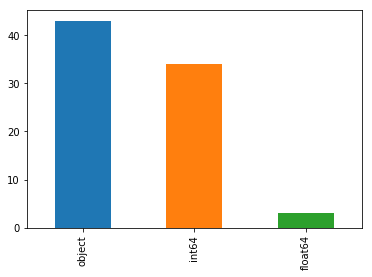

In [226]:
count = pd.value_counts(df_train.dtypes)
count.plot.bar()
plt.show()

## On this dataset we try to predict SalePrice. So let's analyze it:

In [227]:
df_train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

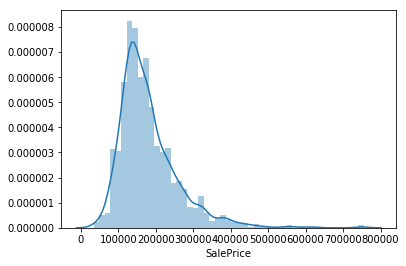

In [228]:
sns.distplot(df_train['SalePrice'])

## Checking for missing values

In [229]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data[missing_data.Total>0]

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageType,81,0.055479
GarageCond,81,0.055479
GarageFinish,81,0.055479
GarageQual,81,0.055479


## Let's analyze these missing values based on data_description.txt

# Some data has levels from Poor to Exc. Can we change Poor to 1 and Exc to 5? Just as OveralQual does.

## PoolQC: Pool quality	
   - Ex  Excellent
   - Gd	Good
   - TA	Average/Typical
   - Fa	Fair
   - NA	No Pool

In [230]:
df_train.PoolQC.fillna('None',inplace=True)
df_train.loc[df_train.PoolQC=='Ex','PoolQC'] = 4
df_train.loc[df_train.PoolQC=='Gd','PoolQC'] = 3
df_train.loc[df_train.PoolQC=='Ta','PoolQC'] = 2
df_train.loc[df_train.PoolQC=='Fa','PoolQC'] = 1
df_train.loc[df_train.PoolQC=='None','PoolQC'] = 0

## MiscFeature: Miscellaneous feature not covered in other categories
   - Elev: Elevator
   - Gar2: 2nd Garage (if not described in garage section)
   - Othr: Other
   - Shed: Shed (over 100 SF)
   - TenC: Tennis Court
   - NA: None
    

In [231]:
print(df_train['MiscFeature'].notnull().sum())
df_train.MiscFeature.fillna('None',inplace=True)

54


## Alley: Type of alley access to property
- Grvl:	Gravel
- Pave:	Paved
- NA: 	No alley access

In [232]:
print(df_train['Alley'].notnull().sum())
df_train.Alley.fillna('None',inplace=True)

91


## Fence: Fence quality
- GdPrv:	Good Privacy
- MnPrv:	Minimum Privacy
- GdWo:	Good Wood
- MnWw:	Minimum Wood/Wire
- NA:	No Fence

In [233]:
print(df_train['Fence'].notnull().sum())
df_train.Fence.fillna('None',inplace=True)

281


## FireplaceQu: Fireplace quality
- Ex:	Excellent - Exceptional Masonry Fireplace
- Gd:	Good - Masonry Fireplace in main level
- TA:	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
- Fa:	Fair - Prefabricated Fireplace in basement
- Po:	Poor - Ben Franklin Stove
- NA:	No Fireplace

In [234]:
print(df_train['FireplaceQu'].notnull().sum())
df_train.FireplaceQu.fillna('None',inplace=True)
df_train.loc[df_train.FireplaceQu=='Ex','FireplaceQu'] = 5
df_train.loc[df_train.FireplaceQu=='Gd','FireplaceQu'] = 4
df_train.loc[df_train.FireplaceQu=='Ta','FireplaceQu'] = 3
df_train.loc[df_train.FireplaceQu=='Fa','FireplaceQu'] = 2
df_train.loc[df_train.FireplaceQu=='Po','FireplaceQu'] = 1
df_train.loc[df_train.FireplaceQu=='None','FireplaceQu'] = 0

770


## LotFrontage: Linear feet of street connected to property


In [235]:
def fill_missing_LotFrontage(df):
    
    #Feature set
    lotFrontage_df = df[['LotFrontage','LotArea','OverallQual','MSSubClass','TotalBsmtSF','1stFlrSF','GrLivArea','BedroomAbvGr','TotRmsAbvGrd','Fireplaces','GarageArea','SalePrice']]
    # Split sets into train and test
    train  = lotFrontage_df.loc[ (df.LotFrontage.notnull()) ]# known Age values
    test = lotFrontage_df.loc[ (df.LotFrontage.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedLotFrontage = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[(df.LotFrontage.isnull()), 'LotFrontage'] = predictedLotFrontage
    
    return df
df_train = fill_missing_LotFrontage(df_train)

## GarageYrBlt: Year garage was built


In [236]:
#Exterior1st, Exterior2nd,ExterQual, Foundation, BsmtQual, GarageFinish,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtQual,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,GarageCars,GarageArea,GarageQual,GarageCond,EnclosedPorch,SalePrice
def fill_missing_age(df):
    #Feature set
    age_df = df[['GarageYrBlt','OverallQual','OverallCond','YearBuilt','YearRemodAdd','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','GarageCars','GarageArea','EnclosedPorch','SalePrice']]
    # Split sets into train and test
    train  = age_df.loc[ (df.GarageYrBlt.notnull()) ]# known Age values
    test = age_df.loc[ (df.GarageYrBlt.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.GarageYrBlt.isnull()), 'GarageYrBlt' ] = predictedAges 
    
    return df
df_train = fill_missing_age(df_train)
df_train.shape

(1460, 80)

## GarageQual: Garage quality
- Ex:	Excellent
- Gd:	Good
- TA:	Typical/Average
- Fa:	Fair
- Po:	Poor
- NA:	No Garage

In [237]:
print(df_train['GarageQual'].notnull().sum())
df_train.GarageQual.fillna('None',inplace=True)
df_train.loc[df_train.GarageQual=='Ex','GarageQual'] = 5
df_train.loc[df_train.GarageQual=='Gd','GarageQual'] = 4
df_train.loc[df_train.GarageQual=='TA','GarageQual'] = 3
df_train.loc[df_train.GarageQual=='Fa','GarageQual'] = 2
df_train.loc[df_train.GarageQual=='Po','GarageQual'] = 1
df_train.loc[df_train.GarageQual=='None','GarageQual'] = 0

1379


## GarageFinish: Interior finish of the garage
- Fin	Finished
- RFn	Rough Finished	
- Unf	Unfinished
- NA	No Garage

In [238]:
print(df_train['GarageFinish'].notnull().sum())
df_train.GarageFinish.fillna('None',inplace=True)

1379


## GarageType: Garage location
- 2Types	More than one type of garage
- Attchd	Attached to home
- Basment	Basement Garage
- BuiltIn	Built-In (Garage part of house - typically has room above garage)
- CarPort	Car Port
- Detchd	Detached from home
- NA	No Garage

In [239]:
print(df_train['GarageType'].notnull().sum())
df_train.GarageType.fillna('None',inplace=True)

1379


## GarageCond: Garage condition
- Ex:	Excellent
- Gd:	Good
- TA:	Typical/Average
- Fa:	Fair
- Po:	Poor
- NA:	No Garage

In [240]:
print(df_train['GarageCond'].notnull().sum())
df_train.GarageCond.fillna('None',inplace=True)
df_train.loc[df_train.GarageCond=='Ex','GarageCond'] = 5
df_train.loc[df_train.GarageCond=='Gd','GarageCond'] = 4
df_train.loc[df_train.GarageCond=='TA','GarageCond'] = 3
df_train.loc[df_train.GarageCond=='Fa','GarageCond'] = 2
df_train.loc[df_train.GarageCond=='Po','GarageCond'] = 1
df_train.loc[df_train.GarageCond=='None','GarageCond'] = 0

1379


## BsmtFinType2: Rating of basement finished area (if multiple types)
- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement

In [241]:
print(df_train['BsmtFinType2'].notnull().sum())
df_train.BsmtFinType2.fillna('None',inplace=True)

1422


## 	BsmtExposure: Refers to walkout or garden level walls
- Gd	Good Exposure
- Av	Average Exposure (split levels or foyers typically score average or above)	
- Mn	Mimimum Exposure
- No	No Exposure
- NA	No Basement

In [242]:
print(df_train['BsmtExposure'].notnull().sum())
df_train.BsmtExposure.fillna('None',inplace=True)

1422


## BsmtCond: Evaluates the general condition of the basement
- Ex:	Excellent
- Gd:	Good
- TA:	Typical - slight dampness allowed
- Fa:	Fair - dampness or some cracking or settling
- Po:	Poor - Severe cracking, settling, or wetness
- NA:	No Basement

In [243]:
print(df_train['BsmtCond'].notnull().sum())
df_train.BsmtCond.fillna('None',inplace=True)
df_train.loc[df_train.BsmtCond=='Ex','BsmtCond'] = 5
df_train.loc[df_train.BsmtCond=='Gd','BsmtCond'] = 4
df_train.loc[df_train.BsmtCond=='TA','BsmtCond'] = 3
df_train.loc[df_train.BsmtCond=='Fa','BsmtCond'] = 2
df_train.loc[df_train.BsmtCond=='Po','BsmtCond'] = 1
df_train.loc[df_train.BsmtCond=='None','BsmtCond'] = 0

1423


## BsmtFinType1: Rating of basement finished area
- GLQ	Good Living Quarters
- ALQ	Average Living Quarters
- BLQ	Below Average Living Quarters	
- Rec	Average Rec Room
- LwQ	Low Quality
- Unf	Unfinshed
- NA	No Basement

In [244]:
print(df_train['BsmtFinType1'].notnull().sum())
df_train.BsmtFinType1.fillna('None',inplace=True)

1423


## BsmtQual: Evaluates the height of the basement
- Ex	Excellent (100+ inches)	
- Gd	Good (90-99 inches)
- TA	Typical (80-89 inches)
- Fa	Fair (70-79 inches)
- Po	Poor (<70 inches)
- NA	No Basement

In [245]:
print(df_train['BsmtQual'].notnull().sum())
df_train.BsmtQual.fillna('None',inplace=True)
df_train.loc[df_train.BsmtQual=='Ex','BsmtQual'] = 5
df_train.loc[df_train.BsmtQual=='Gd','BsmtQual'] = 4
df_train.loc[df_train.BsmtQual=='TA','BsmtQual'] = 3
df_train.loc[df_train.BsmtQual=='Fa','BsmtQual'] = 2
df_train.loc[df_train.BsmtQual=='Po','BsmtQual'] = 1
df_train.loc[df_train.BsmtQual=='None','BsmtQual'] = 0

1423


## MasVnrType: Masonry veneer type
- BrkCmn	Brick Common
- BrkFace	Brick Face
- CBlock	Cinder Block
- None	None
- Stone	Stone

In [246]:
df_train.MasVnrType.fillna('None',inplace=True)

## MasVnrArea: Masonry veneer area in square feet

In [247]:
def fill_missing_MasVnrArea(df):
    
    #Feature set
    age_df = df[['MasVnrArea','LotFrontage','OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtQual','BsmtFinSF1','TotalBsmtSF','1stFlrSF','GrLivArea','FullBath','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','SalePrice','MasVnrType']]
    age_df = pd.get_dummies(age_df)
    # Split sets into train and test
    train  = age_df.loc[ (df.MasVnrArea.notnull()) ]# known Age values
    test = age_df.loc[ (df.MasVnrArea.isnull()) ]# null Ages
    
    # All age values are stored in a target array
    y = train.values[:, 0]
    
    # All the other values are stored in the feature array
    X = train.values[:, 1::]
    
    # Create and fit a model
    rtr = RandomForestRegressor(n_estimators=2000, n_jobs=-1)
    rtr.fit(X, y)
    
    # Use the fitted model to predict the missing values
    predictedAges = rtr.predict(test.values[:, 1::])
    
    # Assign those predictions to the full data set
    df.loc[ (df.MasVnrArea.isnull()), 'MasVnrArea' ] = predictedAges 
    
    return df
df_train = fill_missing_MasVnrArea(df_train)

## Electrical: Electrical system
- SBrkr	Standard Circuit Breakers & Romex
- FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
- FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
- FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
- Mix	Mixed

## Because there is only 1 value missing, and we won't predict the value we will drop this row.

In [248]:
df_train.dropna(subset=['Electrical'],inplace=True)

## Analyzing features

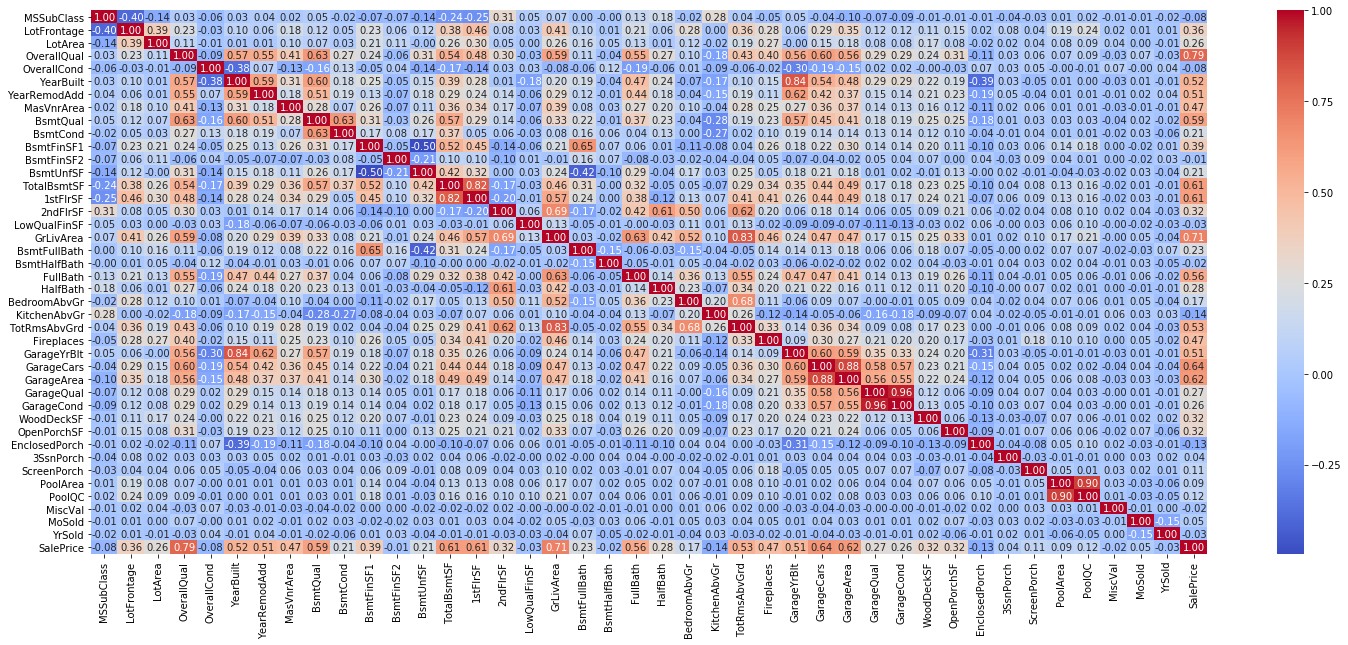

In [249]:
# df_train=pd.read_csv('train.csv')
corr = df_train.corr()
# for i in corr.keys():
#     if i in df_train.keys() and i != 'MasVnrArea':
#         df_train.drop([i],axis=1,inplace=True)
# df_train = pd.get_dummies(df_train)
# for i in df_train.keys():
#     if (df_train[i].corr(df_train['MasVnrArea']) > 0.5 or df_train[i].corr(df_train['MasVnrArea']) < -0.5):
#         print('Correlation ',i,'and MasVnrArea:', df_train[i].corr(df_train['MasVnrArea']))
# for i in corr.keys():
#     if corr[i].corr(corr['MasVnrArea']) > 0.4 or corr[i].corr(corr['MasVnrArea']) < -0.4:
#         print('Correlation ',i,'and MasVnrArea:', corr[i].corr(corr['MasVnrArea']))
f, ax = plt.subplots(figsize=(25, 10))
sns.heatmap(corr,annot=True, fmt = ".2f", cmap = "coolwarm")